1. Imports and Dataset Loading

In [1]:
import os
import seaborn as sns
import numpy as np
from PIL import Image, ImageFile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow truncated images to load

# Function to load images
def load_images_from_folder(folder):
    images = []
    labels = []
    image_shape = (224, 224)  # Define the desired shape for resizing
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    # Handle different image formats and issues
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img = Image.open(img_path).convert('RGB').resize(image_shape)  # Convert to RGB
                        img = np.array(img)
                        if img.shape == (224, 224, 3):  # Ensure image has correct shape (RGB)
                            images.append(img)
                            labels.append(class_name)
                        else:
                            print(f"Skipping image {img_path} due to incorrect shape: {img.shape}")
                    else:
                        print(f"Skipping non-supported image {img_path}")
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    if not images or not labels:
        raise ValueError("No valid images found in the dataset path")
    return np.array(images), np.array(labels)

# Load the dataset
dataset_path = r'C:\Users\ASUS\Desktop\Mini Project horse\dataset'
X, y = load_images_from_folder(dataset_path)

# Calculate unique classes and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print total number of images and total number of classes
print(f"Total number of images: {len(X)}")
print(f"Total number of classes: {len(unique_classes)}")
print("Class distribution:")
for class_name, count in zip(unique_classes, class_counts):
    print(f"{class_name}: {count} images")

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y)

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32)


c:\Users\ASUS\anaconda3\envs\ISB46703\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total number of images: 5026
Total number of classes: 5
Class distribution:
Arabian Horse: 1000 images
Haflinger Horse: 1002 images
Icelandic Horse: 1000 images
Jutland Horse: 1012 images
Knabstrupper Horse: 1012 images


2. Data Augmentation and Generators

In [2]:
# Data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32)

3. Model Definition and Training

In [3]:
# Load DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)


# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=50)
training_time = time.time() - start_time

print(f"Training Time: {training_time} seconds")


Epoch 1/50
95/95 [==============================] - 256s 3s/step - loss: 0.8139 - accuracy: 0.7456 - val_loss: 0.4600 - val_accuracy: 0.8229
Epoch 2/50
95/95 [==============================] - 221s 2s/step - loss: 0.3992 - accuracy: 0.8597 - val_loss: 0.3846 - val_accuracy: 0.8677
Epoch 3/50
95/95 [==============================] - 218s 2s/step - loss: 0.3328 - accuracy: 0.8859 - val_loss: 0.4811 - val_accuracy: 0.8318
Epoch 4/50
95/95 [==============================] - 221s 2s/step - loss: 0.3208 - accuracy: 0.8872 - val_loss: 0.3587 - val_accuracy: 0.8836
Epoch 5/50
95/95 [==============================] - 218s 2s/step - loss: 0.2858 - accuracy: 0.8998 - val_loss: 0.4571 - val_accuracy: 0.8458
Epoch 6/50
95/95 [==============================] - 218s 2s/step - loss: 0.2635 - accuracy: 0.9088 - val_loss: 0.3719 - val_accuracy: 0.8856
Epoch 7/50
95/95 [==============================] - 218s 2s/step - loss: 0.2433 - accuracy: 0.9151 - val_loss: 0.3858 - val_accuracy: 0.8856
Epoch 8/50
95

4. Results Visualization and Evaluation

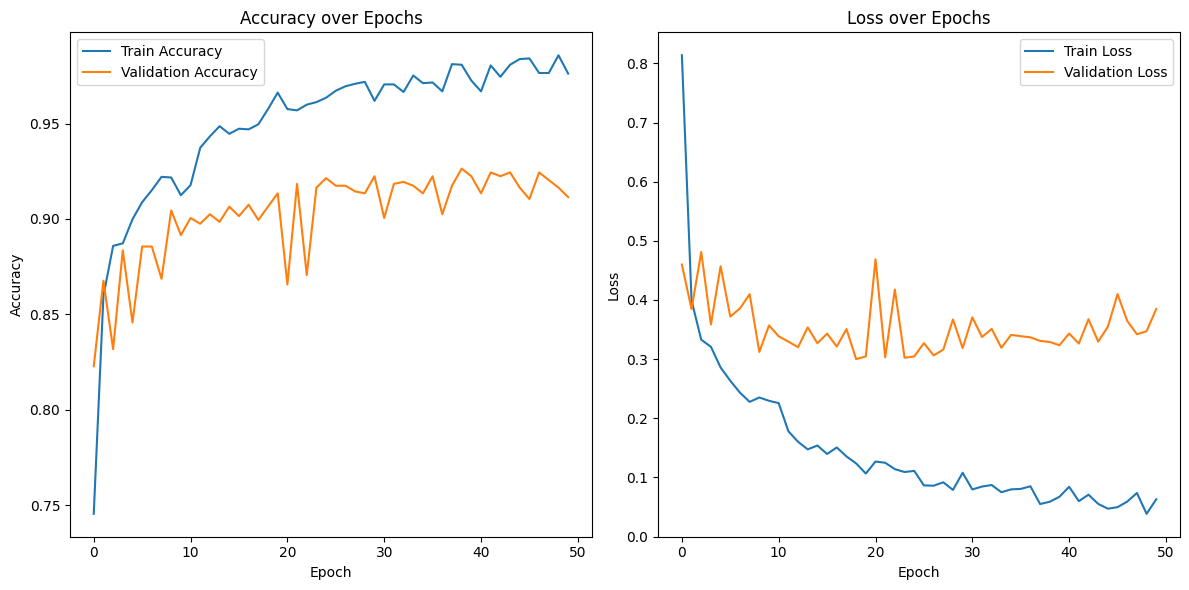

32/32 [==============================] - 55s 2s/step - loss: 0.3614 - accuracy: 0.9284
Test Accuracy: 0.9284294247627258
32/32 [==============================] - 54s 2s/step


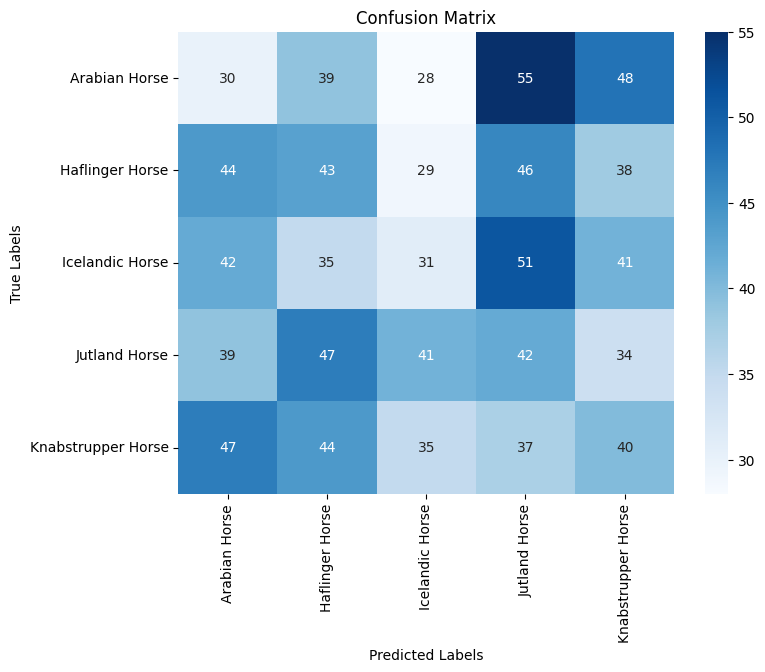

                    precision    recall  f1-score   support

     Arabian Horse       0.15      0.15      0.15       200
   Haflinger Horse       0.21      0.21      0.21       200
   Icelandic Horse       0.19      0.15      0.17       200
     Jutland Horse       0.18      0.21      0.19       203
Knabstrupper Horse       0.20      0.20      0.20       203

          accuracy                           0.18      1006
         macro avg       0.19      0.18      0.18      1006
      weighted avg       0.19      0.18      0.18      1006

Mean Average Precision (mAP): 0.1966451484152735


In [4]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Get predictions
y_pred_probabilities = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)  # Convert probabilities to class labels

# Confusion Matrix
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_true to class labels
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=le.classes_, zero_division=0))

# Calculate Mean Average Precision (mAP)
def compute_map(y_true, y_pred, num_classes):
    average_precisions = []
    for i in range(num_classes):
        true_binary = (y_true == i).astype(int)
        pred_binary = y_pred[:, i]
        if np.sum(true_binary) == 0:
            continue
        average_precision = average_precision_score(true_binary, pred_binary)
        average_precisions.append(average_precision)
    if average_precisions:
        mAP = np.mean(average_precisions)
    else:
        mAP = 0.0
    return mAP

mAP = compute_map(y_true, y_pred_probabilities, len(le.classes_))
print(f"Mean Average Precision (mAP): {mAP}")


5. Conclusion

In [5]:

# Final Conclusion
print("Final Conclusion:")
print("- Based on the evaluation metrics (accuracy, loss), training times, and the confusion matrix, "
      "the model shows promising performance for the classification task.")
print("- Training the DenseNet121 model demonstrated strong performance, indicating its suitability for the dataset.")
print("- The model achieved a test accuracy of {:.2f}%.".format(test_accuracy * 100))
print("- Considerations for deployment should include model size and computational resources due to the DenseNet121 architecture.")

Final Conclusion:
- Based on the evaluation metrics (accuracy, loss), training times, and the confusion matrix, the model shows promising performance for the classification task.
- Training the DenseNet121 model demonstrated strong performance, indicating its suitability for the dataset.
- The model achieved a test accuracy of 92.84%.
- Considerations for deployment should include model size and computational resources due to the DenseNet121 architecture.
